In [1]:
import h5py
import keras as k
import numpy as np
import tensorflow as tf
#import tensorflow.keras as k2 ,
from keras.layers import Dense, Input
from model_parameters import *


Number of spins: 6.67E+05
Reference shift: -3194.374 kHz


In [2]:
x_RK=[]
y_RK=[]
ruta_chinchetas = f'RK'
with open(ruta_chinchetas, 'r') as archivo:
    for linea in archivo:

        valores = linea.split()

        x_RK.append(float(valores[0]))
        y_RK.append(float(valores[1]))

# Cosas plots

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Creamos la PINN

In [4]:
class ODE_2nd(tf.keras.Model):
    def set_ODE_param(
        self,
        t0,
        x0,
        omega,
        omega_c,
        omega_j,
        kappa,
        N_spin,
        pesos,
        g_j,
        ro_j,
        gamma2,
        gamma,
        N_tot,
        DBC,
        pos_DBC,
        bin_resonator,
        line_couplings
    ):
        """
        Set parameters and initial conditions for the ODE
        """
        self.t0 = tf.constant([t0], dtype=tf.float32)
        self.x0_true = tf.constant(x0, dtype=tf.float32)
        self.omega = tf.constant(omega, dtype=tf.float32)
        self.omega_c = tf.constant(omega_c, dtype=tf.float32)
        self.omega_j = tf.constant(omega_j, dtype=tf.float32)
        self.kappa = tf.constant(kappa, dtype=tf.float32)
        self.N_spin = tf.constant(N_spin, dtype=tf.float32)
        self.pesos = tf.constant(pesos, dtype=tf.float32)
        self.g_j = tf.constant(g_j, dtype=tf.float32)
        self.ro_j = tf.constant(ro_j, dtype=tf.float32)
        self.gamma2 = tf.constant(gamma2, dtype=tf.float32)
        self.gamma = tf.constant(gamma, dtype=tf.float32)
        self.N_tot = tf.constant(N_tot, dtype=tf.int32)
        self.DBC = tf.constant(DBC, dtype=tf.float32)
        self.pos_DBC = tf.constant(pos_DBC, dtype=tf.float32)
        self.bin_resonator = tf.constant(bin_resonator, dtype=tf.float32)
        self.line_couplings= tf.constant(line_couplings, dtype=tf.float32)

    def train_step(self, data):
        """
        Training ocurrs here
        """
        t, x_true = data
        with tf.GradientTape() as tape:
            # * Initial conditions
            tape.watch(self.t0)
            tape.watch(self.x0_true)
            tape.watch(t)

            with tf.GradientTape() as tape0:
                tape0.watch(self.t0)
                x0_pred = self(self.t0, training=False)
                tape0.watch(x0_pred)

            with tf.GradientTape() as tape1:
                tape1.watch(t)
                x = self(t, training=False)
                tape1.watch(x)
            dx_dt = tape1.jacobian(x, t)
            dx_dt = tf.squeeze(dx_dt)
            dx_dt = tf.reshape(dx_dt, shape=x.shape)
            tape.watch(t)
            tape.watch(x)
            tape.watch(dx_dt)

            idx = tf.cast(tf.round(t[:, 0]), tf.int32)  # (batch_size,)
            idx = tf.clip_by_value(idx, 0, 1000)  # garantiza que idx ∈ [0, 1000]
            bin_values = tf.gather(self.bin_resonator, idx)  # (batch_size,)
            bin_values = tf.reshape(bin_values, (-1, 1))  # (batch_size, 1)
            line_values = tf.gather(self.line_couplings, idx)  # (batch_size,)
            line_values = tf.reshape(line_values, (-1, 1))  # (batch_size, 1)

            # ? Alternative ODE's order (2)
            lossODE = (
                self.compiled_loss(
                    dx_dt[:, 0],
                    (self.omega_c - self.omega) * x[:, 1]
                    - self.kappa * x[:, 0]
                    - tf.reduce_sum(
                        (
                            -self.g_j
                            * tf.sqrt(self.N_spin)
                            * self.pesos
                            * self.ro_j
                            / tf.sqrt(2.0)
                            * x[:, self.N_tot + 2 : 2 * self.N_tot + 2]
                        )
                        - bin_values / tf.sqrt(2 * self.N_spin)
                    ),
                )
                + self.compiled_loss(
                    dx_dt[:, 1],
                    -(self.omega_c - self.omega) * x[:, 0]
                    - self.kappa * x[:, 1]
                    - tf.reduce_sum(
                        (
                            -self.g_j
                            * tf.sqrt(self.N_spin)
                            * self.pesos
                            * self.ro_j
                            / tf.sqrt(2.0)
                        )
                        * x[:, 2 : self.N_tot + 2]
                    ),
                )
                + tf.reduce_mean(
                    self.compiled_loss(
                        dx_dt[:, 2 : self.N_tot + 2],
                        -(self.omega_c - self.omega)
                        * dx_dt[:, self.N_tot + 2 : 2 * self.N_tot + 2]
                        - self.gamma2 * x[:, 2 : 2 + self.N_tot]
                        - tf.sqrt(2.0 * self.N_spin)
                        * self.g_j
                        * x[:, 2 * self.N_tot + 2 :]
                        * x[:, 1]+ line_values*(x[:,2+2*self.N_tot :]-x[:,2+self.N_tot:2+2*self.N_tot]),
                    )
                )
                + tf.reduce_mean(
                    self.compiled_loss(
                        dx_dt[:, self.N_tot + 2 : 2 * self.N_tot + 2],
                        (self.omega_c - self.omega) * dx_dt[:, 2 : self.N_tot + 2]
                        - self.gamma2 * x[:, self.N_tot + 2 : 2 * self.N_tot + 2]
                        - tf.sqrt(2.0 * self.N_spin)
                        * self.g_j
                        * x[:, 2 * self.N_tot + 2 :]
                        * x[:, 0]+ line_values*(-x[:,2+2*self.N_tot :]+x[:,2:2+self.N_tot]),
                    )
                )
                + tf.reduce_mean(
                    self.compiled_loss(
                        dx_dt[:, 2 * self.N_tot + 2 :],
                        tf.sqrt(2.0 * self.N_spin * self.g_j)
                        * (
                            x[:, 2 : 2 + self.N_tot] * x[:, 1]
                            + x[:, 2 + self.N_tot : 2 + 2 * self.N_tot] * x[:, 0]
                        )
                        - self.gamma
                        * (
                            x[:, 2 + 2 * self.N_tot :]
                            + 1 / (self.N_spin * self.pesos * self.ro_j)
                        )+ line_values*(-x[:,2+self.N_tot : 2+2*self.N_tot]-x[:,2:2+self.N_tot]),
                    )
                )
            )
            print(lossODE)

            # * initial condition loss
            lossBC = self.compiled_loss(x0_pred, self.x0_true)

            # * "Chinchetas" loss
            DBC_NN = self(self.pos_DBC, training=False)
            loss = lossODE + lossBC + self.compiled_loss(self.DBC, DBC_NN) * 5

        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(x_true, x)
        metrics = {m.name: m.result() for m in self.metrics}
        metrics.pop("mean_squared_error")
        metrics["lossreal"] = loss
        metrics["lossODE"] = lossODE
        metrics["lossBC"] = lossBC
        metrics["t"] = t
        metrics["x0"] = x0_pred[:, 0]
        metrics["y0"] = x0_pred[:, 1]
        metrics["vx0"] = x0_pred[:, 2]
        metrics["vy0"] = x0_pred[:, 3]
        return metrics


class FourierLayer(tf.keras.layers.Layer):
    def __init__(self, output_dim, scale=10.0):
        super(FourierLayer, self).__init__()
        self.output_dim = output_dim
        self.scale = scale

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.B = self.add_weight(
            shape=(input_dim, self.output_dim),
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0),
            trainable=False,
        )

    def call(self, inputs):
        projection = tf.matmul(inputs, self.B) * self.scale
        return tf.concat([tf.sin(projection), tf.cos(projection)], axis=-1)


In [5]:
# *We set the inicial conditions
x0 = [0, 0, 0, 0,0,0, -1,-1]
N_total=2

In [6]:
# * Input and output neurons (from the data)
input_neurons = 1
output_neurons = 3 * N_total + 2


# * Define the model
initializer = tf.keras.initializers.GlorotUniform(seed=5)
activation = "tanh"
input = Input(shape=(input_neurons,))
x = Dense(500, activation=activation, kernel_initializer=initializer)(input)
x = Dense(500, activation=activation, kernel_initializer=initializer)(x)
x = Dense(500, activation=activation, kernel_initializer=initializer)(x)
x = Dense(500, activation=activation, kernel_initializer=initializer)(x)
x = Dense(500, activation=activation, kernel_initializer=initializer)(x)
output = Dense(output_neurons, kernel_initializer=initializer, activation=None)(x)

model = ODE_2nd(input, output)

# Cargar los pesos

In [19]:
tmin=0
tmax=400
N_train=100

t_red=np.linspace(tmin,tmax,N_train)
t_red=np.reshape(t_red,(N_train,1))


model.load_weights(f"pesos/inter=4_t=400_lr=1e-05.h5")
y_pred_lr5 = model.predict(t_red)

model.load_weights(f"pesos/inter=4_t=400_lr=1e-06.h5")
y_pred_lr6=model.predict(t_red)

4/4 [==============================] - 0s 2ms/step


# Cargar chinchetas

In [20]:

aux1=[]
chinchetas_x=[]
chinchetas_y=[]
chinchetas_sx1=[]
chinchetas_sx2=[]
chinchetas_sy1=[]
chinchetas_sy2=[]
chinchetas_sz1=[]
chinchetas_sz2=[]


ruta_chinchetas = f'DBC/Ninter=4_t=400_lr=1e-06.txt'
with open(ruta_chinchetas, 'r') as archivo:
    for linea in archivo:

        valores = linea.split()

        aux1.append(float(valores[0]))
        chinchetas_x.append(float(valores[1]))
        chinchetas_y.append(float(valores[2]))
        chinchetas_sx1.append(float(valores[3]))
        chinchetas_sx2.append(float(valores[4]))
        chinchetas_sy1.append(float(valores[5]))
        chinchetas_sy2.append(float(valores[6]))
        chinchetas_sz1.append(float(valores[7]))
        chinchetas_sz2.append(float(valores[8]))
        


# Calculo

In [21]:
def compute_shift(evol_sz, dist_freqs, dist_coup, omega_c, Gamma):

    freqs, weights = dist_freqs[0], dist_freqs[1]
    couplings, w_g, N_spins = dist_coup[0], dist_coup[1], dist_coup[2]

    D_i = freqs - omega_c
    g_j = couplings * np.sqrt(N_spins * weights * w_g)
    G_J = g_j * g_j * (evol_sz + 1.0)
    spin_comp = G_J * D_i / (D_i * D_i + Gamma * Gamma)
    return spin_comp.sum()



In [22]:
sigma_lr5 = []
sigma_lr6=[]

for i in range(N_train):
    aux = compute_shift(
        y_pred_lr5[i][ 2 * N_total + 2:],
        dist_freqs,
        [dist_rescoup, w_coup, N_spins],
        omega_c,
        Gamma,
    )
    sigma_lr5.append(aux / 2 / np.pi * 1e6)
    aux = compute_shift(
        y_pred_lr6[i][2 * N_total + 2:],
        dist_freqs,
        [dist_rescoup, w_coup, N_spins],
        omega_c,
        Gamma,
    )
    sigma_lr6.append(aux / 2 / np.pi * 1e6)


Hiperparámetros de la simulación:
  N_coup: 2
  Ndisc: 1
  Nspins: 667455.8967486444
  T1: 15000000000.0
  T2: 400.0
  detuning: 0.12583535713542915
  driving_frequency: 17.304395033118762
  gamma_s: 0.06283185307179587
  integration_delta_t: 0.1
  kappa: 5.5e-05
  kappa_ext: 5.5e-08
  n_points: 101
  omega_c: 17.178559675983333
  omega_s: 17.304395033118762
  power: -15.0
  pulsetime: 1000
  couplings: <HDF5 dataset "couplings": shape (2,), type "<f8">


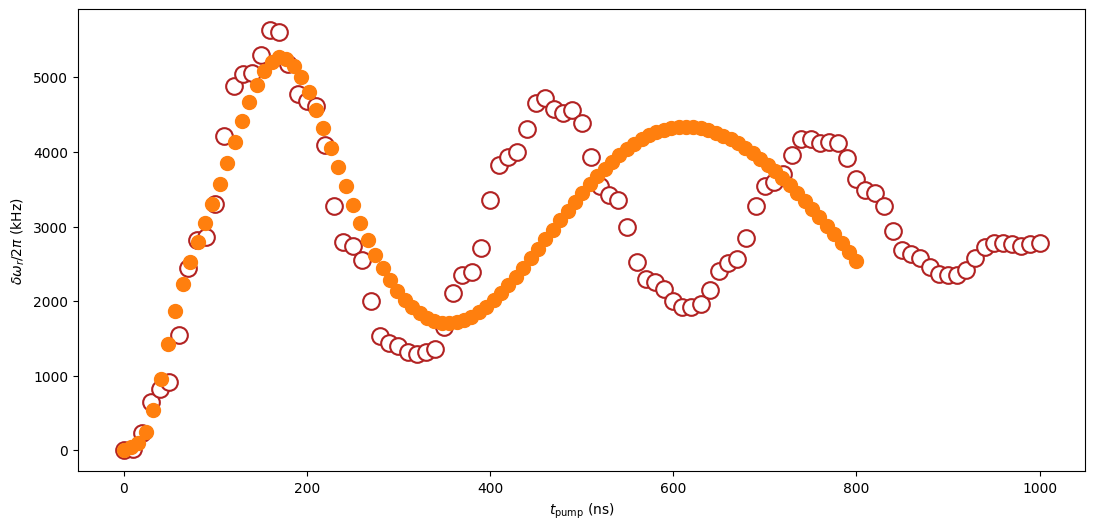

In [26]:
def plot_results(filename):
    with h5py.File(filename, "r") as f:
        hyper = f["Hyperparameters"]
        print(f"Hiperparámetros de la simulación:")

        for attr_name, attr_value in hyper.attrs.items():
            print(f"  {attr_name}: {attr_value}")

        for dset_name in hyper:
            dset_value = hyper[dset_name]
            print(f"  {dset_name}: {dset_value}")

    with h5py.File(filename, "r") as f:
        hyper = f["Hyperparameters"]
        driving_freq = hyper.attrs["driving_frequency"]
        pulse_time = hyper.attrs["pulsetime"]
        n_points = hyper.attrs["n_points"]

    with h5py.File(filename, "r") as f:
        sim = f[f"Experiment_omega_{driving_freq:.5f}"]
        results = sim["Results"][:]

    shifts = np.abs(results[..., -1]) / 2 / np.pi * 1e6

    fig, ax = plt.subplots(1, 1, figsize=(13, 6))

    tp_list = np.linspace(0, pulse_time, n_points)
    ax.plot(tp_list, shifts, "o", ms=12, mew=1.5, mfc="white", mec="firebrick")
    ax.plot(t_red, sigma_lr6, marker='o',markersize=10.0, linestyle='solid', linewidth=0, label=r"lr=10$^{-5}$")
    
    ax.set_ylabel(r"$\delta\omega_r/2\pi$ (kHz)")
    ax.set_xlabel(r"$t_{\mathrm{pump}}$ (ns)")

    plt.show()

plot_results("Results/SDNdisc1Ncoup2_4.h5")

# Plots


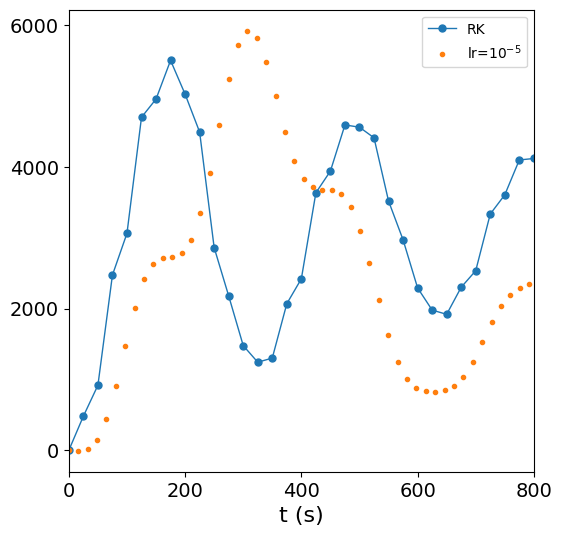

In [ ]:
fig, ax = plt.subplots(dpi=100)
# aux=y_pred_lr5[:,-1]/2/np.pi*1e6
# t_red=t_red*2
# #* PINN
# ax.plot(t_red,
#         y_pred_lr6[:,-1],
#         marker='o',
#         markersize=5,
#         linestyle='solid',
#         linewidth=1,
#         label=r"PINN")

#* PINN
ax.plot(x_RK,
        y_RK,
        marker='o',
        markersize=5.0,
        linestyle='solid',
        linewidth=1,
        label=r"RK")
ax.plot(t_red, sigma_lr5, marker='o',markersize=3.0, linestyle='solid', linewidth=0, label=r"lr=10$^{-5}$")

#*"Chinchetas"
# ax.plot(aux1, chinchetas_sz1, "o", markersize=6)


ax.tick_params(axis='both', which='major', labelsize=14)

ax.set_xlabel('t (s)', fontsize=16)

#* Adds a legend
ax.legend(fontsize=19, frameon=False)
ax.legend()

ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
ax.yaxis.set_major_locator(ticker.MaxNLocator(4))

plt.grid(False)  # Optional
# plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
#                 mode="expand", borderaxespad=0, ncol=2,fontsize=12)
ax.set_xlim(0,800)
fig.set_size_inches(6,6)
#?Save the plot
#fig.savefig(f'figuras definitivas/Black_hole_velocity_chinchetas={N_intervalo}_y={y_ini}_N={N_train}_.png',bbox_inches='tight', dpi=600)

plt.show()

In [28]:
loss5=[]
loss_IC5=[]
loss_ODE5 = []

loss6=[]
loss_IC6=[]
loss_ODE6=[]


ruta_loss1 = f'loss/Ninter=4_t=400_lr=1e-05.txt'
with open(ruta_loss1, 'r') as archivo:
    for linea in archivo:

        valores = linea.split()

        loss5.append(float(valores[0]))
        loss_IC5.append(float(valores[1]))
        loss_ODE5.append(float(valores[2]))

ruta_loss2 = f'loss/Ninter=4_t=400_lr=1e-06.txt'
with open(ruta_loss2, 'r') as archivo:
    for linea in archivo:

        valores = linea.split()

        loss6.append(float(valores[0]))
        loss_IC6.append(float(valores[1]))
        loss_ODE6.append(float(valores[2]))

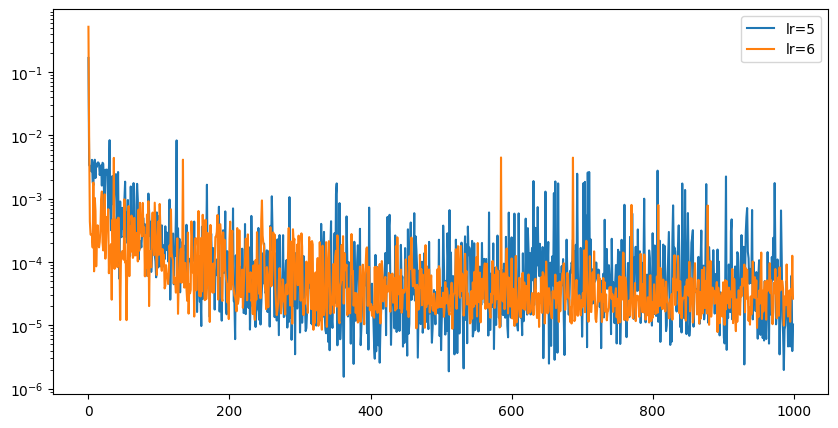

In [29]:

loss_red5=[]
loss_red6=[]
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(len(loss5)):
    if (i%10==0):
        loss_red5.append(loss5[i])
        loss_red6.append(loss6[i])

ax.plot(loss_red5, label="lr=5")
ax.plot(loss_red6, label="lr=6")
ax.legend(fontsize=19, frameon=False)
ax.legend()

ax.set_yscale("log")